<a href="https://colab.research.google.com/github/panaali/GAN-lab/blob/master/Keras_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras-GAN
The goal of this document is to test different GAN implementation with different parameters.

## Instruction
* For running the code on GPU: Runtime > Change runtime type > Hardware Accelerator > GPU
* For running all the cells: ⌘/Ctrl + F9




In [0]:
# Install Dependencies
# No Dependencies

In [0]:
# Import libraries
from __future__ import print_function, division


from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys
import os
import time
import shutil

import numpy as np

The process is as follows:

  


In [0]:
class GAN:
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 100

    optimizer = Adam(0.0002, 0.5)

    # Build and compile the discriminator
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy'])

    # Build the generator
    self.generator = self.build_generator()

    # The generator takes noise as input and generates imgs
    z = Input(shape=(self.latent_dim,))
    img = self.generator(z)

    # For the combined model we will only train the generator
    self.discriminator_frozen = Model(inputs=self.discriminator.inputs,
                      outputs=self.discriminator.outputs)
    self.discriminator_frozen.trainable = False

    # The discriminator takes generated images as input and determines validity
    validity = self.discriminator_frozen(img)

    # The combined model  (stacked generator and discriminator)
    # Trains the generator to fool the discriminator
    self.combined = Model(inputs=z, outputs=validity)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


  def build_generator(self):

    model = Sequential()

    model.add(Dense(256, input_dim=self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))
    print('Generator Model:')
    model.summary()

    noise = Input(shape=(self.latent_dim,))
    img = model(noise)

    return Model(inputs=noise, outputs=img)

  def build_discriminator(self):

    model = Sequential()

    model.add(Flatten(input_shape=self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    print('Discriminator Model:')
    model.summary()

    img = Input(shape=self.img_shape)
    validity = model(img)

    return Model(inputs=img, outputs=validity)

  def train(self, epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()
    
    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

      # ---------------------
      #  Train Discriminator
      # ---------------------

      # Generate a batch of new images
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      gen_imgs = self.generator.predict(noise)
      
      # Select a random batch of images
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]


      # Train the discriminator
      d_loss_real = self.discriminator.train_on_batch(imgs, valid)
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      # ---------------------
      #  Train Generator
      # ---------------------

      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

      # Train the generator (to have the discriminator label samples as valid)
      g_loss = self.combined.train_on_batch(noise, valid)

      # Plot the progress
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

      # If at save interval => save generated image samples
      if epoch % sample_interval == 0:
        self.sample_images(epoch)

  def sample_images(self, epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, self.latent_dim))
    gen_imgs = self.generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
    fig.savefig("./images/%d.png" % epoch)
    plt.close()

In [31]:
  start_time = time.time()
  shutil.rmtree('./images', ignore_errors=True)
  os.makedirs('./images', exist_ok=True)
  
  gan = GAN()
  gan.train(epochs=301, batch_size=32, sample_interval=200)
  print("--- %s seconds ---" % (time.time() - start_time))

Discriminator Model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________

In [4]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

m = 100
n = 100
matrix = np.random.normal(0,1,m*n).reshape(m,n)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,100):
    ax.clear()
    ax.plot(matrix[i,:])
    fig.canvas.draw()
plt.title("3D Bar Chart Example")
plt.show()

<IPython.core.display.Javascript object>

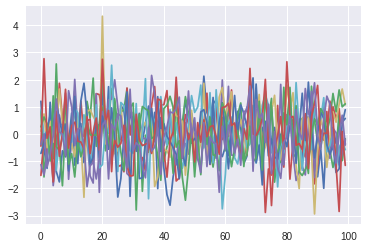

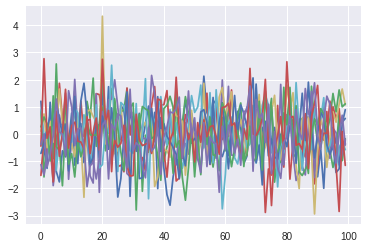

In [8]:
import time
import pylab as pl
from IPython import display
for i in range(10):
    pl.plot(pl.randn(100))
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(1.0)